# PySpark

In [6]:
import pyspark
sc = pyspark.SparkContext('local[*]')

In [8]:
txt = sc.textFile(r'C:\Projects\TCA\KMS_ENTITY_CI\tca_product_ml\TCA_Product_ML_Model\co_kms_2.txt')
print(txt.count())

37


In [9]:
python_lines = txt.filter(lambda line: 'cora-ar-rq-qa' in line.lower())
print(python_lines.count())

1


In [17]:
#import required packages
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#read the data
df = pd.read_excel(r"C:\Users\Rimanshu\Downloads\AirQualityUCI\AirQualityUCI.xlsx", parse_dates=[['Date', 'Time']])

#check the dtypes
df.head()

,Date_Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10 18:00:00,2.6,1360.00,150,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.60,48.875001,0.757754
1,2004-03-10 19:00:00,2.0,1292.25,112,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.30,47.700000,0.725487
2,2004-03-10 20:00:00,2.2,1402.00,88,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.90,53.975000,0.750239
3,2004-03-10 21:00:00,2.2,1375.50,80,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.00,60.000000,0.786713
4,2004-03-10 22:00:00,1.6,1272.25,51,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.15,59.575001,0.788794


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 14 columns):
Date_Time        9357 non-null datetime64[ns]
CO(GT)           9357 non-null float64
PT08.S1(CO)      9357 non-null float64
NMHC(GT)         9357 non-null int64
C6H6(GT)         9357 non-null float64
PT08.S2(NMHC)    9357 non-null float64
NOx(GT)          9357 non-null float64
PT08.S3(NOx)     9357 non-null float64
NO2(GT)          9357 non-null float64
PT08.S4(NO2)     9357 non-null float64
PT08.S5(O3)      9357 non-null float64
T                9357 non-null float64
RH               9357 non-null float64
AH               9357 non-null float64
dtypes: datetime64[ns](1), float64(12), int64(1)
memory usage: 1023.5 KB


In [18]:
df['Date_Time'] = pd.to_datetime(df.Date_Time , format = '%d/%m/%Y %H.%M.%S')
data = df.drop(['Date_Time'], axis=1)
data.index = df.Date_Time

In [20]:
#missing value treatment
cols = data.columns
for j in cols:
    for i in range(0,len(data)):
        if data[j][i] == -200:
            data[j][i] = data[j][i-1]

#checking stationarity
from statsmodels.tsa.vector_ar.vecm import coint_johansen
#since the test works for only 12 variables, I have randomly dropped
#in the next iteration, I would drop another and check the eigenvalues
johan_test_temp = data.drop([ 'CO(GT)'], axis=1)
coint_johansen(johan_test_temp,-1,1).eig

C:\Users\Rimanshu\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


array([1.75628733e-01, 1.52399674e-01, 1.15090998e-01, 1.04309966e-01,
       9.29562919e-02, 6.90255307e-02, 5.76654697e-02, 3.43596700e-02,
       3.06350634e-02, 1.18801270e-02, 2.46819409e-03, 7.09473977e-05])

In [21]:
#creating the train and validation set
train = data[:int(0.8*(len(data)))]
valid = data[int(0.8*(len(data))):]

#fit the model
from statsmodels.tsa.vector_ar.var_model import VAR

model = VAR(endog=train)
model_fit = model.fit()

# make prediction on validation
prediction = model_fit.forecast(model_fit.y, steps=len(valid))

C:\Users\Rimanshu\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\Rimanshu\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


In [34]:
prediction[:1]

array([[8.88161065e-01, 8.41803964e+02, 2.71644320e+02, 1.98263201e+00,
        5.95965721e+02, 1.37030660e+02, 1.11961516e+03, 8.78153392e+01,
        8.29844660e+02, 5.46026663e+02, 1.05743863e+01, 3.48713152e+01,
        4.37277520e-01]])

In [26]:
import numpy as np
from sklearn.metrics import mean_squared_error
#converting predictions to dataframe
pred = pd.DataFrame(index=range(0,len(prediction)),columns=[cols])
for j in range(0,13):
    for i in range(0, len(prediction)):
        pred.iloc[i][j] = prediction[i][j]

#check rmse
for i in cols:
    print('rmse value for', i, 'is : ', np.sqrt(mean_squared_error(pred[i], valid[i])))

rmse value for CO(GT) is :  1.408696542445898
rmse value for PT08.S1(CO) is :  205.91037633779467
rmse value for NMHC(GT) is :  6.670741427623062
rmse value for C6H6(GT) is :  7.130304477788332
rmse value for PT08.S2(NMHC) is :  277.8562837310263
rmse value for NOx(GT) is :  214.75793797686748
rmse value for PT08.S3(NOx) is :  244.96129928948912
rmse value for NO2(GT) is :  66.65226538129396
rmse value for PT08.S4(NO2) is :  490.05286652865937
rmse value for PT08.S5(O3) is :  446.5049918901908
rmse value for T is :  10.722429361263574
rmse value for RH is :  17.114848634833294
rmse value for AH is :  0.5216105887695887


In [31]:
pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1872 entries, 0 to 1871
Data columns (total 13 columns):
(CO(GT),)           1872 non-null object
(PT08.S1(CO),)      1872 non-null object
(NMHC(GT),)         1872 non-null object
(C6H6(GT),)         1872 non-null object
(PT08.S2(NMHC),)    1872 non-null object
(NOx(GT),)          1872 non-null object
(PT08.S3(NOx),)     1872 non-null object
(NO2(GT),)          1872 non-null object
(PT08.S4(NO2),)     1872 non-null object
(PT08.S5(O3),)      1872 non-null object
(T,)                1872 non-null object
(RH,)               1872 non-null object
(AH,)               1872 non-null object
dtypes: object(13)
memory usage: 190.2+ KB


In [106]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
# Above is a special style template for matplotlib, highly useful for visualizing time series data
from pylab import rcParams
rcParams['figure.figsize'] = 10, 7
df = pd.read_csv(r'C:\Users\Rimanshu\Downloads\power_actual.csv', date_parser='datetime')
df.head()

,Unnamed: 0,datetime,ghi,gti,power
0,0,2017-10-01 00:00:00,0.0,0.0,0.0
1,1,2017-10-01 00:15:00,0.0,0.0,0.0
2,2,2017-10-01 00:30:00,0.0,0.0,0.0
3,3,2017-10-01 00:45:00,0.0,0.0,0.0
4,4,2017-10-01 01:00:00,0.0,0.0,0.0


In [107]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70080 entries, 0 to 70079
Data columns (total 5 columns):
Unnamed: 0    70080 non-null int64
datetime      70080 non-null object
ghi           35040 non-null float64
gti           35040 non-null float64
power         70080 non-null float64
dtypes: float64(3), int64(1), object(1)
memory usage: 2.7+ MB


In [110]:
df['power'].describe()

count    70080.000000
mean        28.612915
std        498.795887
min          0.000000
25%          0.000000
50%          0.000000
75%          5.540000
max      16172.040000
Name: power, dtype: float64

In [111]:
df['power'].value_counts()

0.000000        42082
12.770000          82
13.020000          80
0.020000           76
9.230000           75
0.040000           75
0.010000           73
0.060000           68
0.660000           67
0.080000           64
0.250000           63
1.400000           63
0.340000           59
0.290000           58
12.320000          57
0.640000           57
2.230000           55
0.230000           55
13.650000          54
12.070000          53
11.380000          53
4.240000           52
12.540000          52
4.730000           52
10.020000          52
11.050000          51
1.540000           51
11.170000          50
11.820000          50
12.040000          50
                ...  
12243.960000        1
8631.220000         1
1.562500            1
0.745714            1
10.969231           1
7475.410000         1
3519.800000         1
6649.050000         1
1.255333            1
11.280833           1
3180.680000         1
4689.530000         1
6956.630000         1
7.212143            1
8248.07000

In [112]:
df= df[df['power'] != 0.00]

In [113]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42082 entries, 0 to 70079
Data columns (total 5 columns):
Unnamed: 0    42082 non-null int64
datetime      42082 non-null object
ghi           35040 non-null float64
gti           35040 non-null float64
power         42082 non-null float64
dtypes: float64(3), int64(1), object(1)
memory usage: 3.2+ MB


In [121]:
df['power'].value_counts()

12.770000       82
13.020000       80
0.020000        76
0.040000        75
9.230000        75
0.010000        73
0.060000        68
0.660000        67
0.080000        64
0.250000        63
1.400000        63
0.340000        59
0.290000        58
0.640000        57
12.320000       57
2.230000        55
0.230000        55
13.650000       54
11.380000       53
12.070000       53
12.540000       52
4.240000        52
4.730000        52
10.020000       52
1.540000        51
11.050000       51
11.170000       50
12.040000       50
11.820000       50
10.780000       49
                ..
3.466923         1
9874.670000      1
17.310000        1
6387.480000      1
14.356667        1
14374.470000     1
3.946154         1
18.150000        1
2390.510000      1
10569.740000     1
14716.620000     1
3.672667         1
0.284375         1
4.492500         1
6.195000         1
16.870000        1
0.147500         1
2555.800000      1
8351.780000      1
2007.150000      1
44.830000        1
17.070000   

In [114]:
df['power'].describe()

count    27998.000000
mean        71.619154
std        787.198737
min          0.010000
25%          3.170000
50%          8.030000
75%         12.360000
max      16172.040000
Name: power, dtype: float64

In [117]:
df = df[['datetime','power']]

In [115]:
df.head()

,Unnamed: 0,datetime,ghi,gti,power
27,27,2017-10-01 06:45:00,NaN,NaN,0.08
28,28,2017-10-01 07:00:00,NaN,NaN,0.34
29,29,2017-10-01 07:15:00,NaN,NaN,0.80
30,30,2017-10-01 07:30:00,NaN,NaN,1.40
31,31,2017-10-01 07:45:00,NaN,NaN,2.23


In [118]:
df['power'].max()

16172.04

In [119]:
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True) #set date as index
df.head()

,power
datetime,
2017-10-01 06:45:00,0.08
2017-10-01 07:00:00,0.34
2017-10-01 07:15:00,0.80
2017-10-01 07:30:00,1.40
2017-10-01 07:45:00,2.23


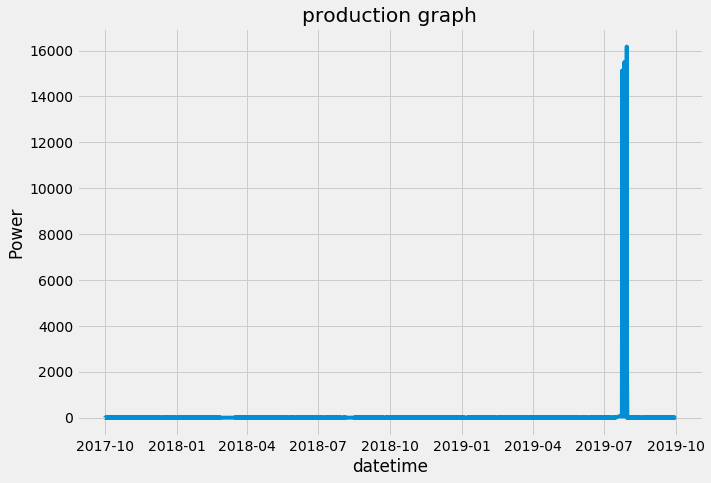

In [120]:
plt.xlabel("datetime")
plt.ylabel("Power")
plt.title("production graph")
plt.plot(df)